In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Bonds') + ['AGG', 'BND', 'BNDX', 'BIV', 'SCHZ'], 50, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-05-20 to 2019-07-09 - 77


In [3]:
stats = quote.statistics()
stats = stats[(stats['shrp'] > 0.2) & (stats['std'] > 0.1)]
print(len(stats))
stats

62


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
BNDX,30,0.468180,0.221731,1.932512,3.020753,0.193599
EMLC,30,1.161316,0.755014,1.485580,7.251704,0.546927
IGIB,30,0.570113,0.422159,1.256470,3.298768,0.788507
VWOB,30,0.734494,0.559375,1.242123,4.208918,0.695306
USIG,30,0.593496,0.450213,1.230114,3.371280,0.821250
VCLT,30,1.107372,0.879122,1.214495,6.527495,1.510670
VCIT,30,0.578639,0.445411,1.210020,3.284810,0.800001
LQD,30,0.759378,0.630287,1.141854,4.340916,1.224685
SPIB,30,0.395395,0.317278,1.121140,2.242309,0.600856


/Users/chaoyi/.local/share/virtualenvs/portfolio_analysis-bdMx2S3t/lib/python3.7/site-packages/scipy/optimize/optimize.py:2341: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


evicted IPE 0.791 -0.360
evicted LMBS 0.729 -0.042
evicted BSCK 0.696 -0.384
evicted SLQD 0.724 -0.236
evicted TLT 0.787 -0.653
evicted VCLT 0.648 -0.068
evicted VWOB 0.791 -0.512
evicted TFI 0.799 -0.315
evicted BWX 0.648 -0.066
evicted CMF 0.688 -0.512
evicted EMLC 0.451 -0.220
evicted CWB 0.152 -0.672
evicted SUB 0.502 0.275
evicted NUV 0.362 -0.194
retry backlogs ['VMBS', 'ITM', 'VTEB', 'HYLB', 'IEF', 'SPIB', 'IEI', 'MBB', 'BSV', 'PZA', 'SJNK', 'STIP', 'VTIP', 'MUB', 'SPTS', 'SCHO', 'HYG', 'SHY', 'VCSH', 'SCHR', 'IBDL', 'AGG', 'TIP', 'BIV', 'USIG', 'BND', 'VGIT', 'SCHZ', 'VCIT', 'SPTL', 'SCHP', 'TDTT', 'VGSH', 'SPSB', 'SHYG', 'IGSB', 'IGIB', 'HYLS', 'ISTB', 'JNK', 'EMB', 'LQD', 'BSJK', 'GOVT', 'HYS', 'BLV'] at 0.805 - 2.031
evicted SPTL 0.764 -0.639
evicted EMB 0.785 -0.286
evicted LQD 0.756 0.184
evicted ISTB 0.500 -0.082
evicted PZA 0.727 -0.406
evicted SHYG 0.217 -0.566
evicted ITM 0.503 0.292
retry backlogs ['VGSH', 'SCHR', 'IGIB', 'VTIP', 'STIP', 'SHY', 'AGG', 'SPTS', 'GOVT', 

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,30.0,0.370437,0.162938,0.049129,0.252896,0.399492,0.483233,0.671700,2.029940,2.412299,0.140653
BNDX,30.0,0.468180,0.221731,0.000000,0.291175,0.517803,0.634484,0.830923,1.932512,3.020753,0.193599
HYD,30.0,0.188368,0.173784,-0.330397,0.104224,0.212954,0.291363,0.562295,0.855577,1.287265,0.409065


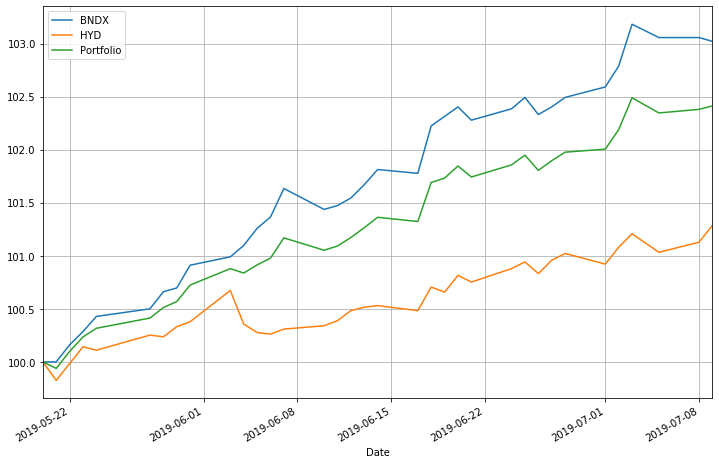

In [4]:
quote.setup_mask(stats.index)
ratio, shrp = quote.optimize_portfolio(.1, backlogs_threshold=.8)
print(ratio, shrp)
quote.setup_mask(ratio)
quote.graph(ratio)